# Data processing

In [426]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
# from datetime import date
%matplotlib inline

import pywt
import copy

### Useful function and common variables

In [427]:
DIAGRAMS_PATH = "./diagrams"
def parse_string_to_datetime(x):
    return datetime.strptime(x, '%Y-%m-%d')

def is_stock_hk(stock_name):
    return ".HK" in stock_name

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

### Read stock price CSVs

In [428]:
raw_marekt_data_path = "./data/raw/market_data/"

# current directory csv files;
#  ref: https://stackoverflow.com/a/55245949/9500852
csvs = [x for x in os.listdir(raw_marekt_data_path) if x.endswith('.csv')]
# stats.csv -> stats
fns = [os.path.splitext(os.path.basename(x))[0] for x in csvs]

d = {}
for i in range(len(fns)):
    d[fns[i]] = pd.read_csv(raw_marekt_data_path + csvs[i])

    # parse also the date from string to Datetime object
    if not isinstance(d[fns[i]]["Date"][0], datetime):
        d[fns[i]]["Date"] = d[fns[i]]["Date"].apply(parse_string_to_datetime)

# show read csv result - Disney's stock
d["DIS"]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2011-09-30,26.557592,27.041898,26.407898,26.557592,15135000,0.0,0
1,2011-10-03,26.443124,26.707291,25.527344,25.536150,13899200,0.0,0
2,2011-10-04,25.298400,26.390290,24.822900,26.293430,19000000,0.0,0
3,2011-10-05,26.724900,27.781567,26.689677,27.746346,17823700,0.0,0
4,2011-10-06,27.499790,28.221847,27.314874,28.204235,12659400,0.0,0
...,...,...,...,...,...,...,...,...
2512,2021-09-24,175.300003,176.699997,175.080002,176.000000,5712800,0.0,0
2513,2021-09-27,176.630005,179.449997,175.960007,178.259995,7755000,0.0,0
2514,2021-09-28,177.750000,178.000000,173.860001,174.520004,9133100,0.0,0
2515,2021-09-29,174.250000,174.960007,172.589996,172.679993,6240800,0.0,0


### Stock data count

In [429]:
hk_stock_row_count = 0
us_stock_row_count = 0

for i in range(len(fns)):
    if is_stock_hk(fns[i]):
        hk_stock_row_count = hk_stock_row_count + len(d[fns[i]])
    else:
        us_stock_row_count = us_stock_row_count + len(d[fns[i]])

print("Rows of HK stocks data: " + str(hk_stock_row_count))
print("Rows of US stocks data: " + str(us_stock_row_count))

Rows of HK stocks data: 121231
Rows of US stocks data: 123839


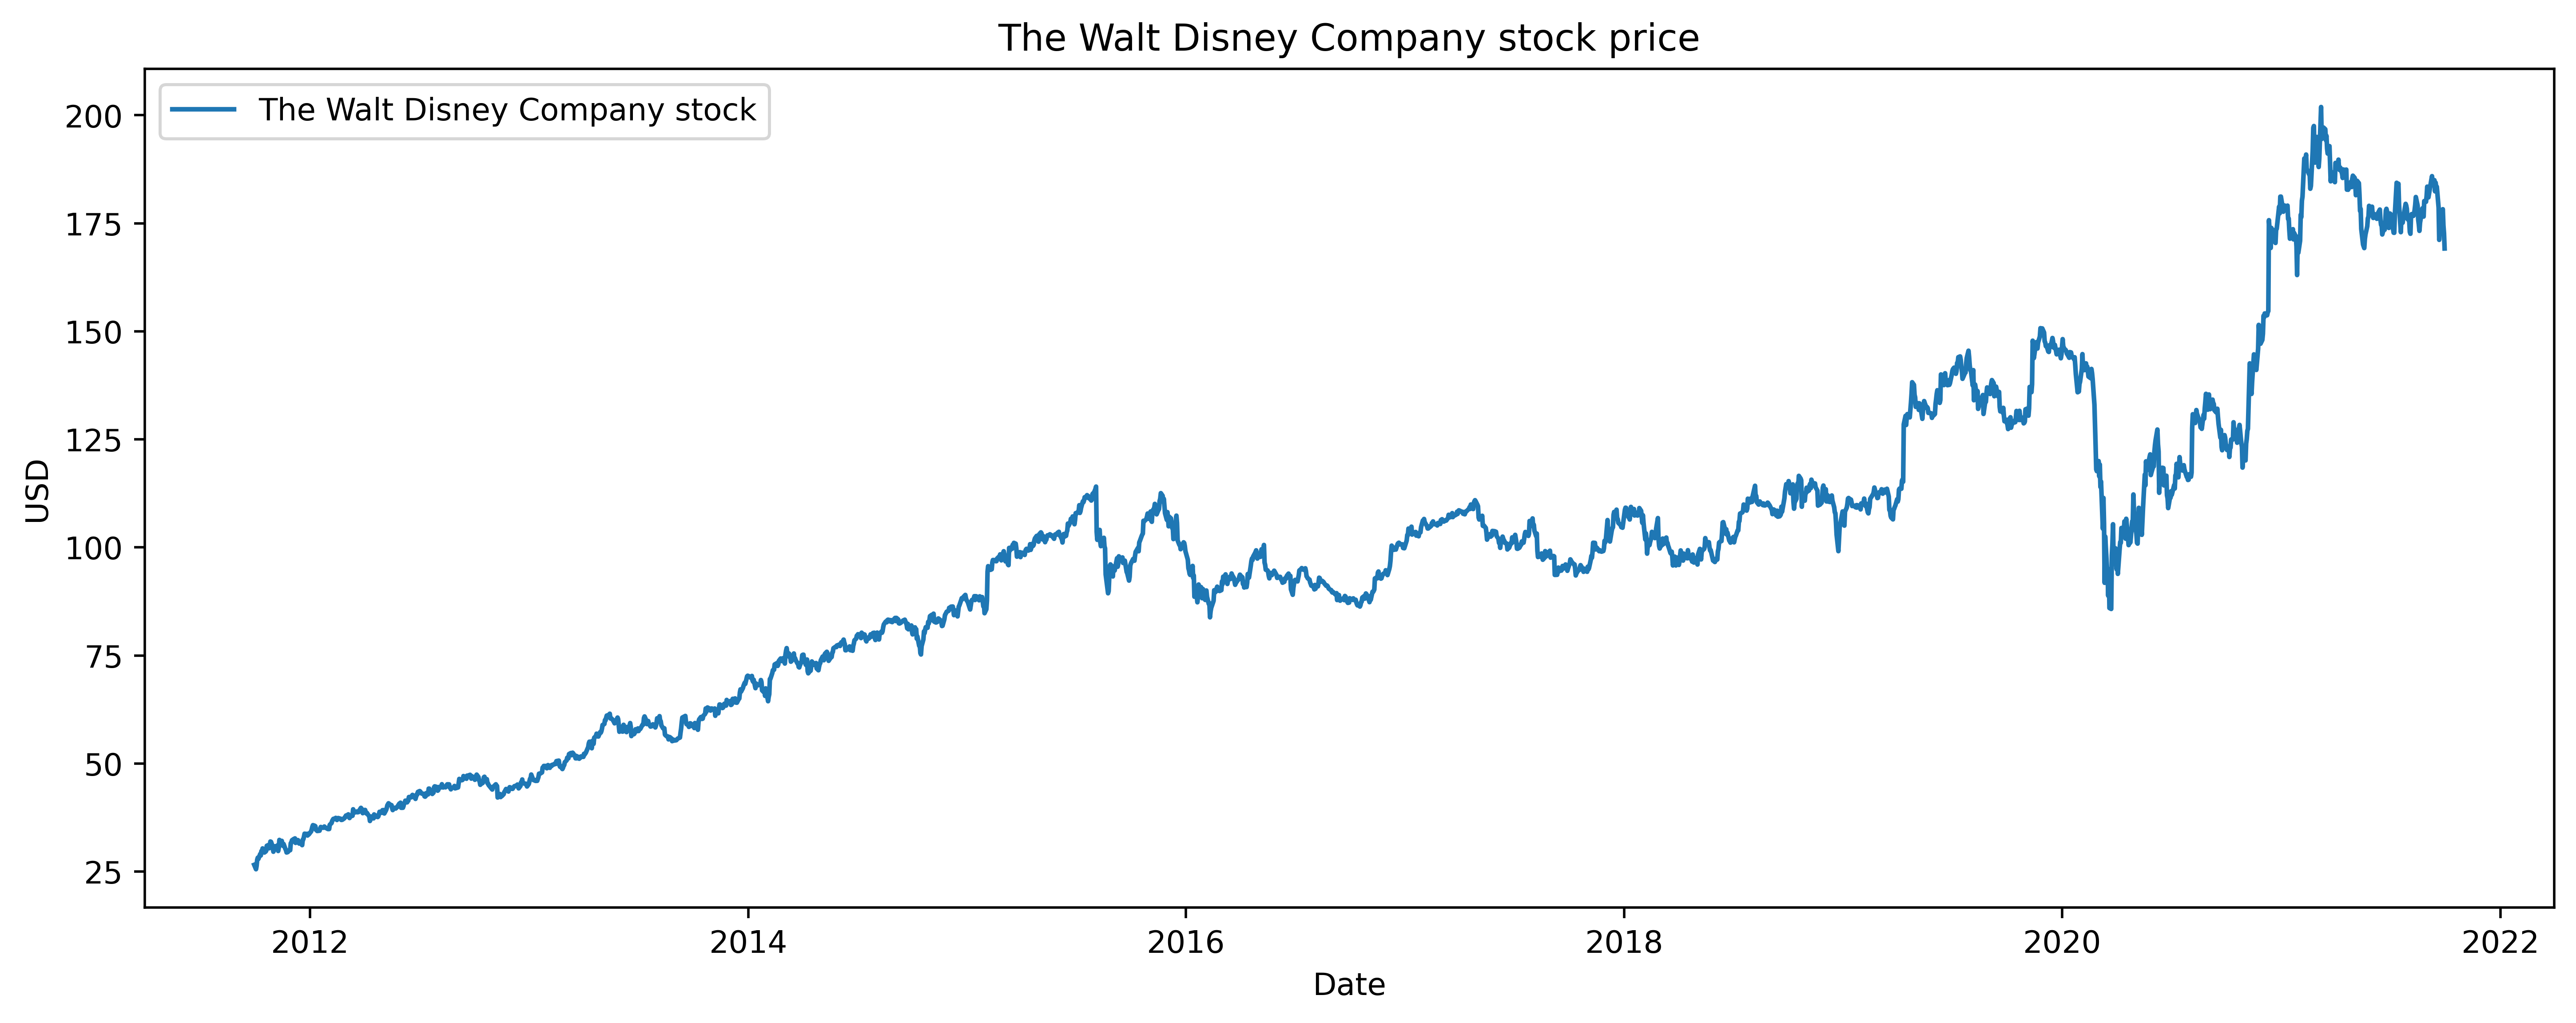

In [430]:
# plot The Walt Disney Company (DIS) stocks price
DIS = d["DIS"]
if not isinstance(DIS["Date"][0], datetime):
    DIS["Date"] = DIS["Date"].apply(parse_string_to_datetime)

plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
plt.plot(DIS['Date'], DIS['Close'], label='The Walt Disney Company stock')
# plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('The Walt Disney Company stock price')
plt.legend()
create_dir_if_not_exist(DIAGRAMS_PATH)
plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
plt.show()

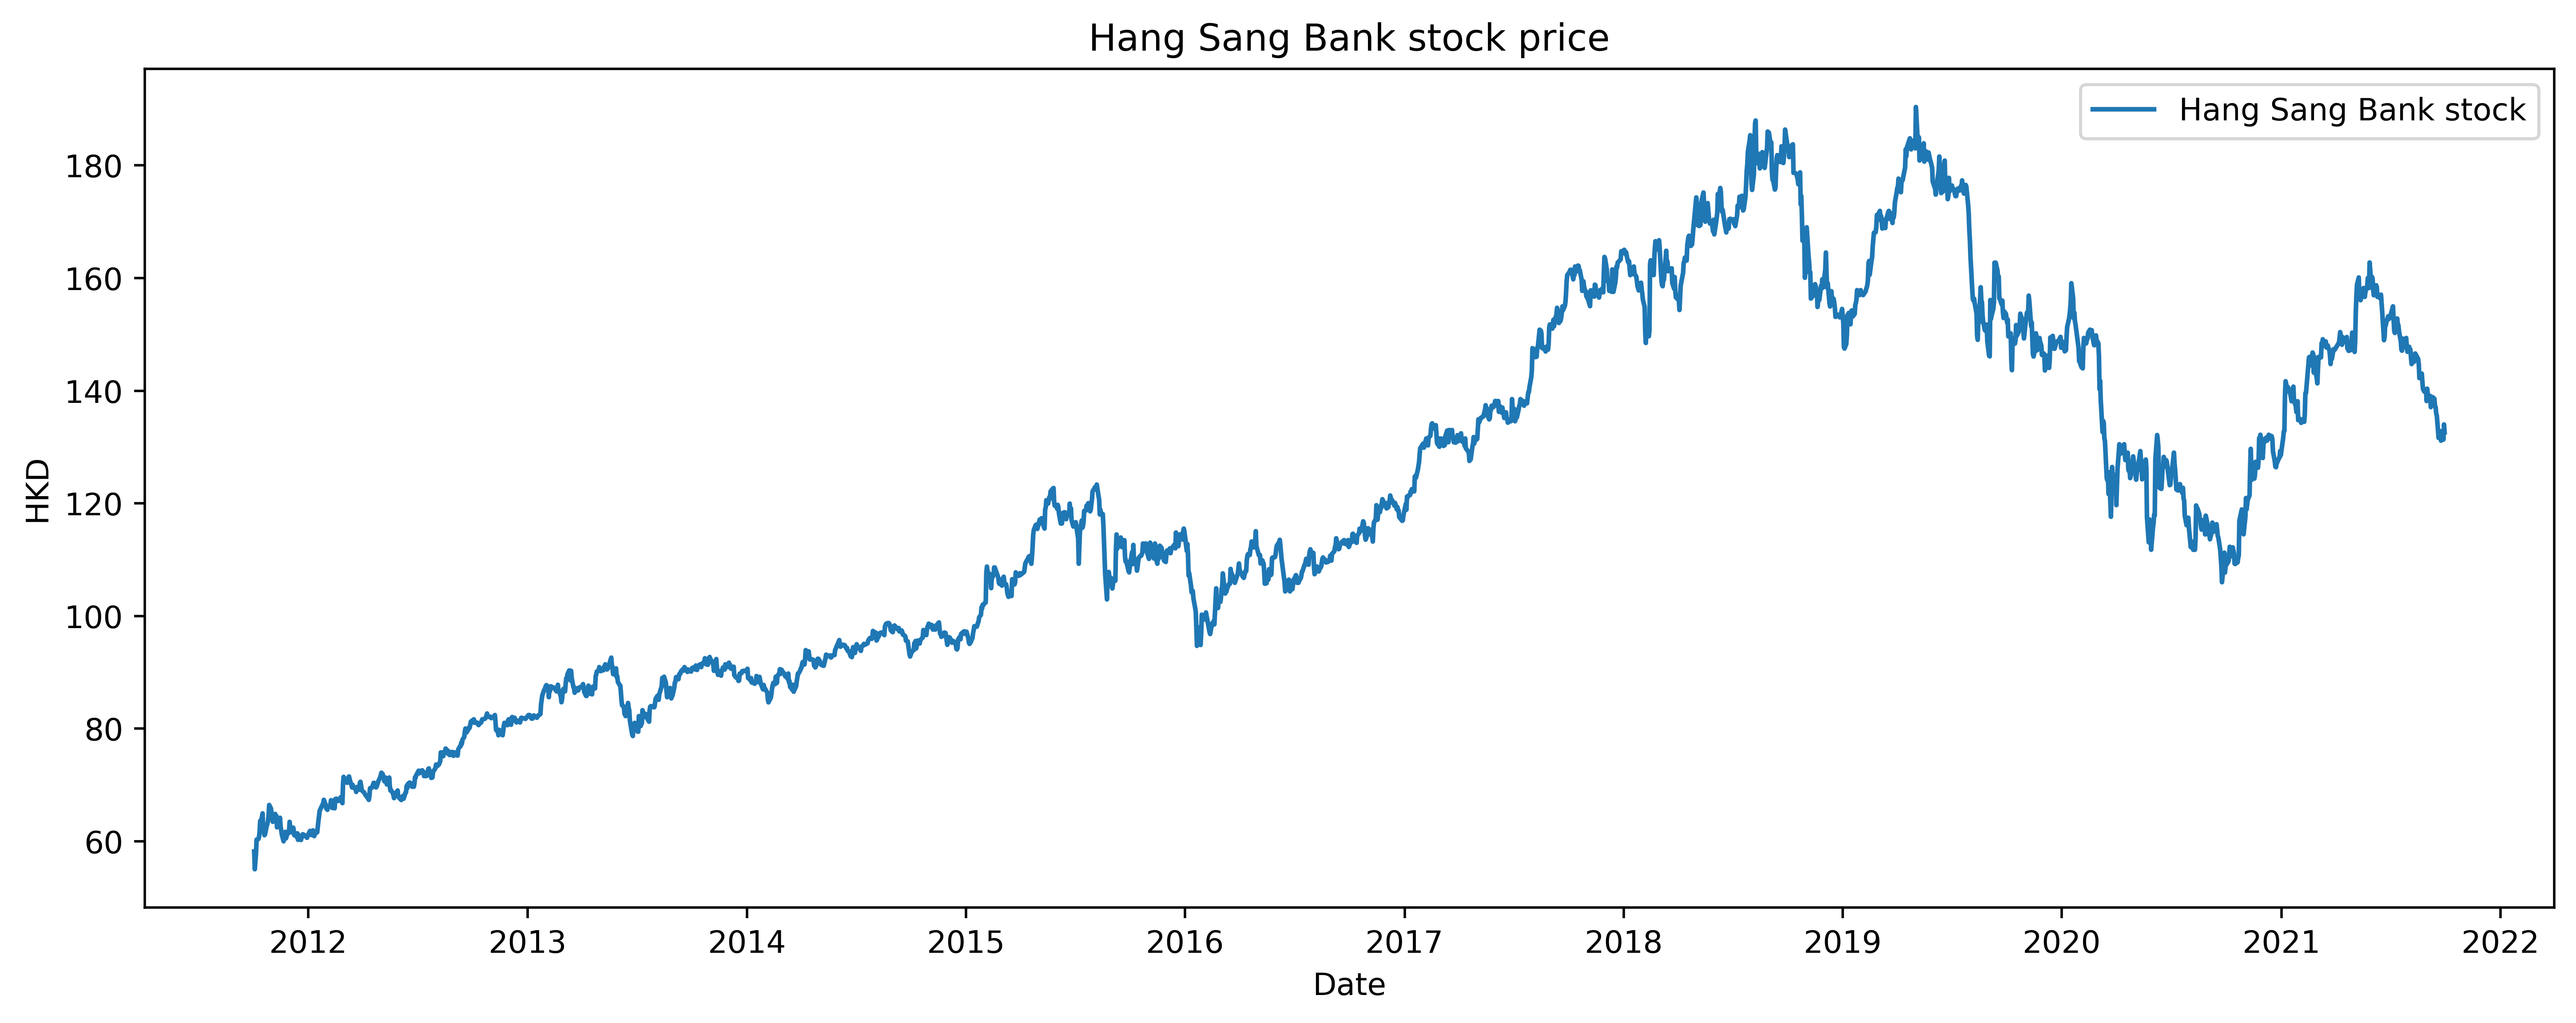

In [431]:
# plot 0011.HK stocks price
HK0011 = d["0011.HK"]
if not isinstance(HK0011["Date"][0], datetime):
    HK0011["Date"] = HK0011["Date"].apply(parse_string_to_datetime)

plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
plt.plot(HK0011['Date'], HK0011['Close'], label='Hang Sang Bank stock')
# plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('HKD')
plt.title('Hang Sang Bank stock price')
plt.legend()
create_dir_if_not_exist(DIAGRAMS_PATH)
plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
plt.show()

### Data denoising

In [432]:
def wavelet_denoise(index_list, wavefunc='haar', lv=2, m=1, n=2, plot=False):

    '''
    *** Reference **
    Obtained from: https://github.com/SunHao95/PHBS_TQFML-StockIndex-Wavelet-Transformation-ARIMA-ML-Model/blob/c1c3c11e80568663448bdc30f87dc378db0538d2/Project/model.py#L19-L68
    Edited to fit the project's requirements
    *** END ***

    WT: Wavelet Transformation Function
    index_list: Input Sequence;

    lv: Decomposing Level；

    wavefunc: Function of Wavelet, 'db4' default；

    m, n: Level of Threshold Processing

    '''

    # Decomposing
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])

    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]

    if plot:
        denoised_index = np.sum(coeff, axis=0)
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
        print(data)

    return coeff

In [433]:
d_denoised = copy.deepcopy(d) # create copy from raw data to prevent overwrite
denoised_count = 0
for i in range(len(fns)):
    tmp_close_price = d_denoised[fns[i]]["Close"]
    coeff = wavelet_denoise(tmp_close_price)
    d_denoised[fns[i]]["Close"] = np.sum(coeff, axis=0) # reconstruct and save to the dataframe
    denoised_count = denoised_count + 1
    print("{} OK".format(fns[i]))

print("Denoised count: {}".format(denoised_count))

UAL OK
1109.HK OK
V OK
2313.HK OK
0027.HK OK
3968.HK OK
WU OK
MSI OK
FCX OK
0003.HK OK
ADM OK
0011.HK OK
GPN OK
0857.HK OK
ARE OK
0001.HK OK
0101.HK OK
FMC OK
AIZ OK
BXP OK
1398.HK OK
0005.HK OK
0941.HK OK
0066.HK OK
2331.HK OK
0017.HK OK
1093.HK OK
0388.HK OK
2319.HK OK
0762.HK OK
2628.HK OK
1044.HK OK
RL OK
0241.HK OK
FTNT OK
JNPR OK
DHI OK
2020.HK OK
EXPE OK
1928.HK OK
KO OK
WDC OK
LUMN OK
UPS OK
MSFT OK
UDR OK
COO OK
2018.HK OK
MLM OK
0267.HK OK
AMD OK
ZBH OK
0386.HK OK
UHS OK
SBAC OK
0002.HK OK
0669.HK OK
LKQ OK
PVH OK
3988.HK OK
GD OK
CLX OK
0688.HK OK
DIS OK
0883.HK OK
LDOS OK
LEN OK
2382.HK OK
AOS OK
OMC OK
1299.HK OK
TSLA OK
TXT OK
1177.HK OK
0012.HK OK
0939.HK OK
0960.HK OK
2388.HK OK
REGN OK
AMGN OK
TEL OK
IFF OK
1038.HK OK
ROST OK
0868.HK OK
2888.HK OK
0700.HK OK
2318.HK OK
0823.HK OK
0175.HK OK
0016.HK OK
TEAM OK
GPC OK
AAPL OK
1211.HK OK
0006.HK OK
EFX OK
WAB OK
2007.HK OK
NWL OK
Denoised count: 100


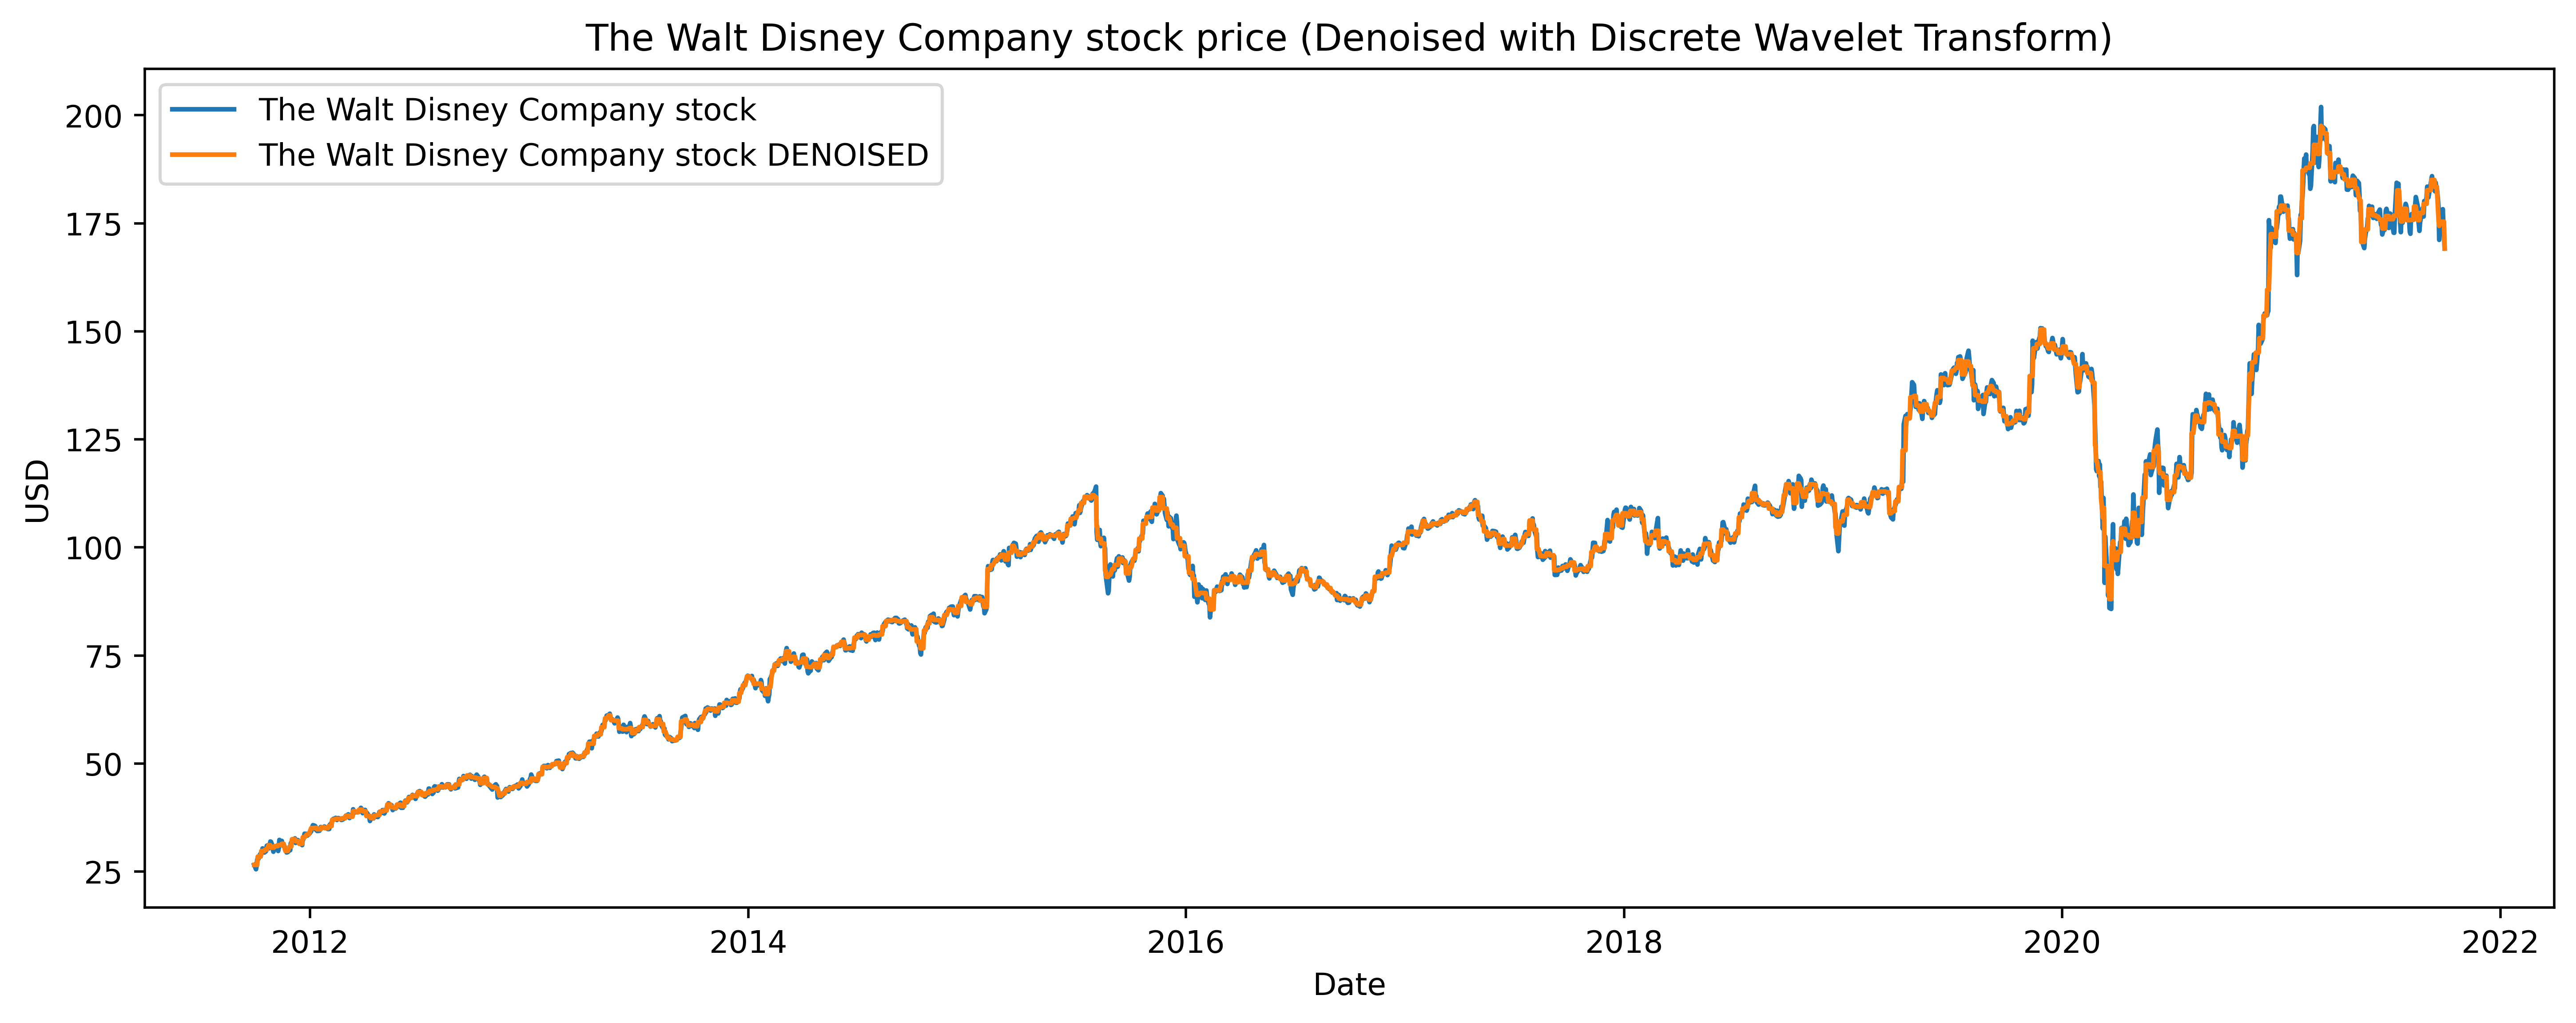

In [434]:
# plot the wavelet transformed (denoised) of Walt Disney Stock
if not isinstance(d_denoised["DIS"]["Date"][0], datetime):
    d_denoised["DIS"]["Date"] = d_denoised["DIS"]["Date"].apply(parse_string_to_datetime)

plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
plt.plot(d["DIS"]['Date'], d["DIS"]['Close'], label='The Walt Disney Company stock')
plt.plot(d_denoised["DIS"]['Date'], d_denoised["DIS"]['Close'], label='The Walt Disney Company stock DENOISED')
# plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('The Walt Disney Company stock price (Denoised with Discrete Wavelet Transform)')
plt.legend()
create_dir_if_not_exist(DIAGRAMS_PATH)
plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
plt.show()

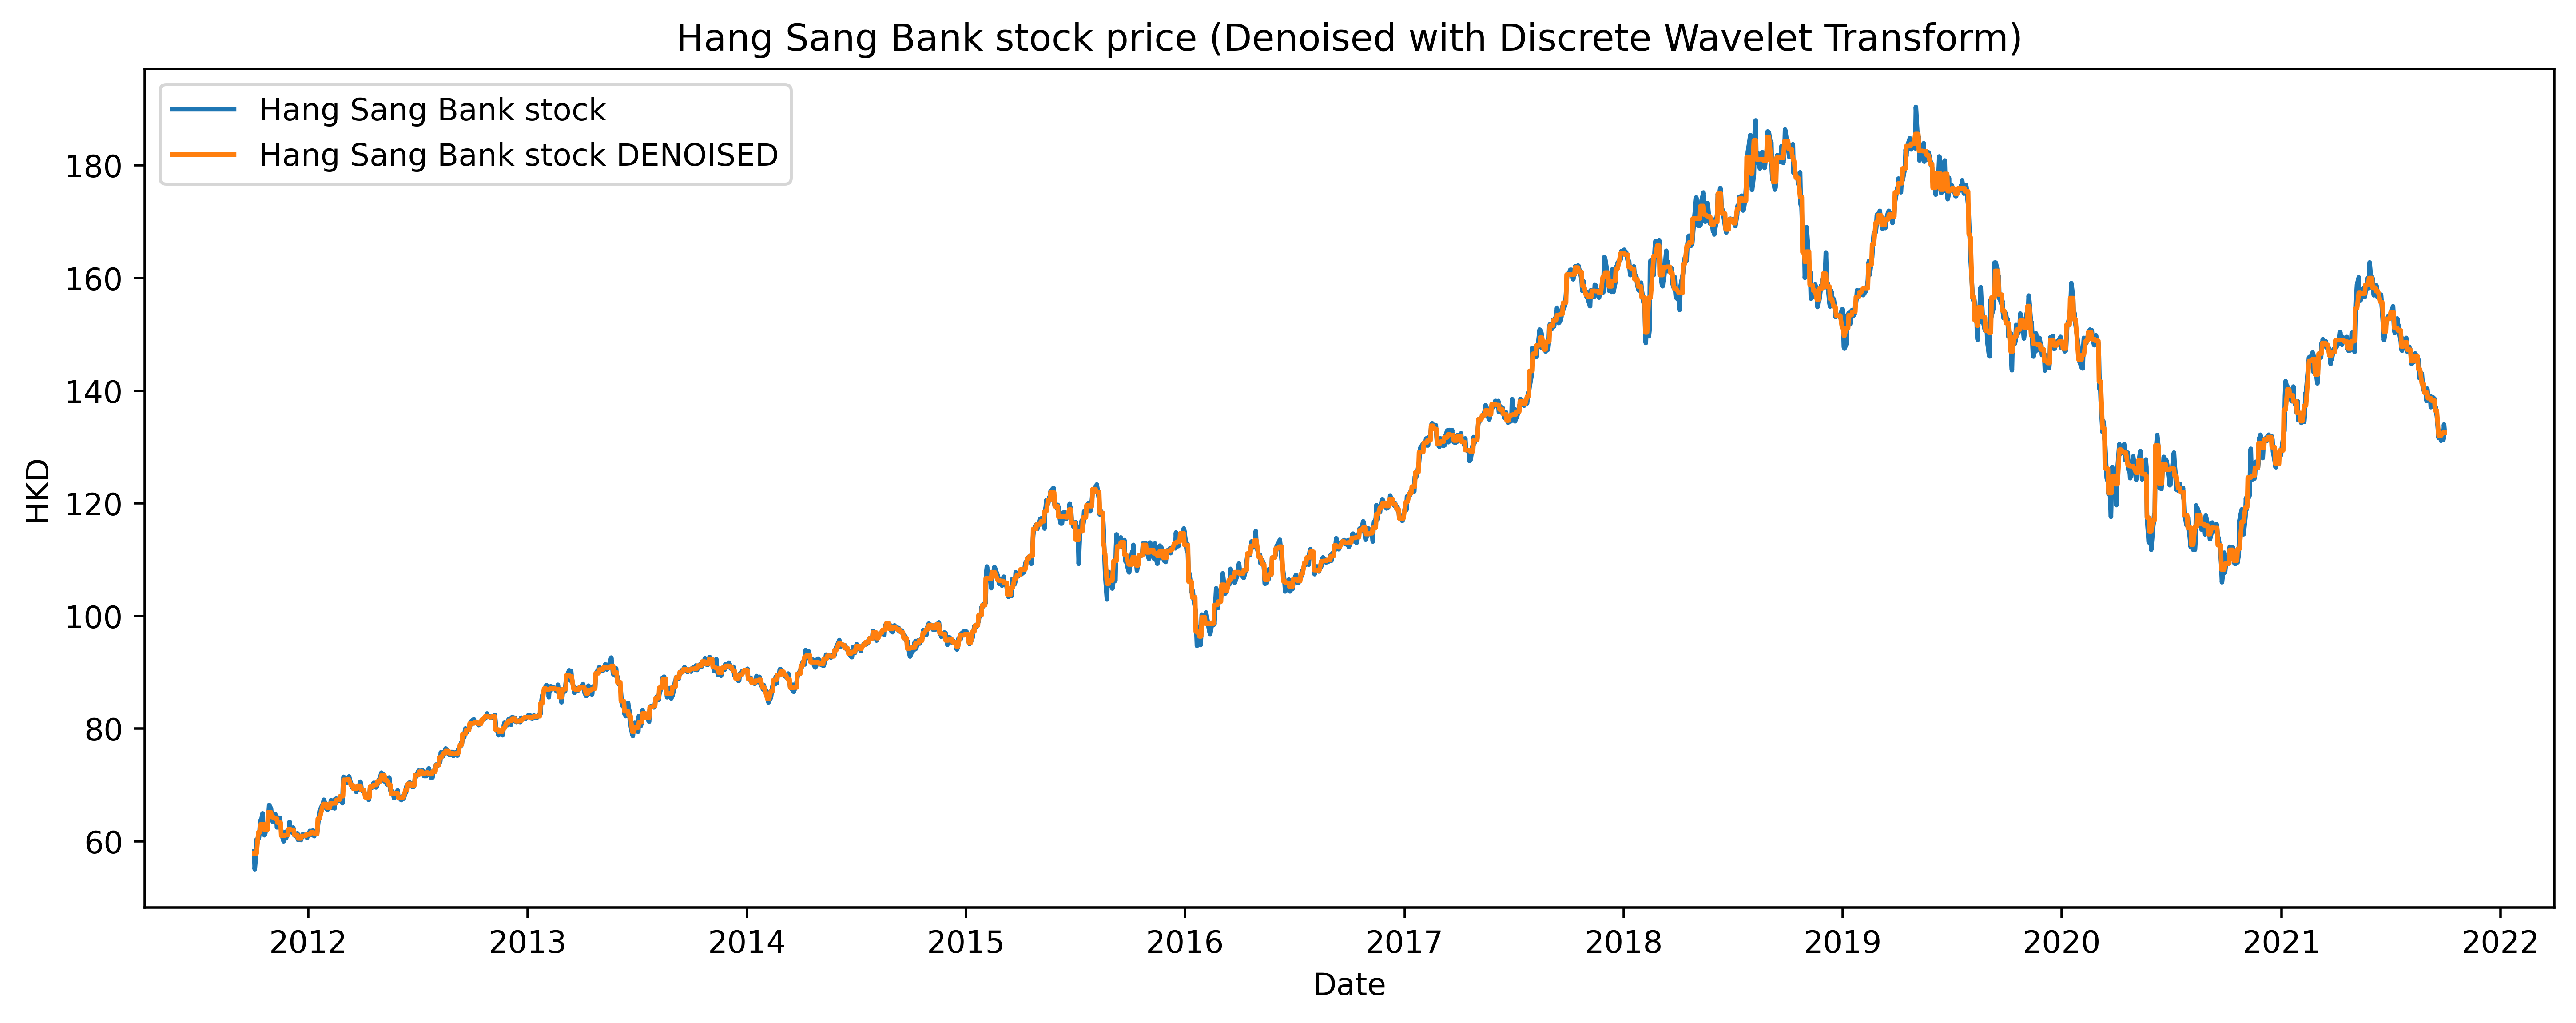

In [435]:
if not isinstance(d_denoised["0011.HK"]["Date"][0], datetime):
    d_denoised["0011.HK"]["Date"] = d_denoised["0011.HK"]["Date"].apply(parse_string_to_datetime)

plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
plt.plot(d["0011.HK"]['Date'], d["0011.HK"]['Close'], label='Hang Sang Bank stock')
plt.plot(d_denoised["0011.HK"]['Date'], d_denoised["0011.HK"]['Close'], label='Hang Sang Bank stock DENOISED')
# plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('HKD')
plt.title('Hang Sang Bank stock price (Denoised with Discrete Wavelet Transform)')
plt.legend()
create_dir_if_not_exist(DIAGRAMS_PATH)
plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
plt.show()
